# Example of Point Process Decoder

For use in point process decoding (sometimes I also use point process filter), we need the following format of inputs:
- Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin
- It should be noted that point process decoding is for **binary-valued spike trains**. Hence, the time bins should be very small to gurantee that most intervals have no more than one spike.
- The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"

In this example, we load Matlab data that contains 
- The spike times of all neurons. In Matlab, "spike_times" is a cell of size "number of neurons" x 1. Within spike_times{i} is a vector containing all the spike times of neuron i.
- A continuous stream of the output variables. In this example, we are aiming to decode velocity. In Matlab, "vels" is a matrix of size "number of recorded time points" x 2 (x and y velocities were recorded) that contains the x and y velocity components at all time points. "vel_times" is a vector that states the time at all recorded time points. 

We will put this data in the format described above, with the help of the functions "bin_spikes" and "bin_output" that are in the file "preprocessing_funcs.py"

This example is similar to those shown in "Examples_kf_decoder." However, there is some preprocessing is different for **Point Process**, so we have made a separate notebook. It should be noted that a **small time bin** should be used to obtain point process observation.

In this example notebook, we:
1. Import the necessary packages
2. Load a data file (spike trains and outputs we are predicting)
3. Preprocess the data
4. Check the intervals and visualize point process observation
5. Run the point process decoders
6. Plot example decoded outputs
7. Evaluating the goodness of fit

- State-space model with Gaussian approximation (Kalman FILTER with Point Process) [Link][1]
- State-space model with sequential Monte Carlo (Particle FILTER with Point Process) [Link][2]

[1]: https://direct.mit.edu/neco/article/16/5/971/6831/Dynamic-Analysis-of-Neural-Encoding-by-Point
[2]: https://direct.mit.edu/neco/article/21/10/2894/7426/Sequential-Monte-Carlo-Point-Process-Estimation-of]

## 1. Import packages and functions

In [1]:
###Import standard packages###
import numpy as np
from scipy import io
import matplotlib.pyplot as plt


#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

###Import functions for binning data for preprocessing###
from Neural_Decoding.preprocessing_funcs import bin_spikes
from Neural_Decoding.preprocessing_funcs import bin_output
%matplotlib inline

## 2. Load Data
The data for this example can be downloaded at this [link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AACPWjxDKPEzQiXKUUFriFkJa?dl=0&preview=s1_data_raw.mat)

It was recorded by Raeed Chowdhury from Lee Miller's lab at Northwestern.

dict_keys(['__header__', '__version__', '__globals__', 'spike_times', 'vels', 'vel_times', 'pos', 'acc'])


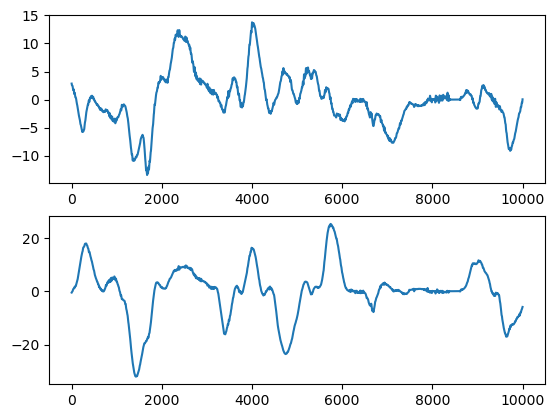

In [2]:
###Load Data###
folder='data/' #ENTER THE FOLDER THAT YOUR DATA IS IN
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/' 
data=io.loadmat(folder+'m1_data_raw.mat')
# data=io.loadmat(folder+'s1_data_raw.mat')
print(data.keys())

spike_times=data['spike_times'] #Load spike times of all neurons
pos = data['pos']
vels=data['vels'] #Load x and y velocities
vel_times=data['vel_times'] #Load times at which velocities were recorded

t_window = np.arange(0,10000,1)
fig, axs = plt.subplots(2, 1)
axs[0].plot(t_window, vels[t_window,0])
axs[1].plot(t_window, vels[t_window,1])


## 3. Preprocess data

In [3]:
dt=.01 #Size of time bins (in seconds)
t_start=vel_times[0] + 30 #Time to start extracting data - here the first time velocity was recorded
# t_end=vel_times[-1] #Time to finish extracting data - here the last time velocity was recorded
t_end = t_start + 120
downsample_factor=1 #Downsampling of output (to make binning go faster). 1 means no downsampling.

print("t start %.2fs and t end %.2fs"%(t_start,t_end))
print("selected: t start %.2fs and t end %.2fs"%(t_start,t_end))

t start 60.00s and t end 180.00s
selected: t start 60.00s and t end 180.00s


### 3.1 Put data in binned format

In [4]:
#When loading the Matlab cell "spike_times", Python puts it in a format with an extra unnecessary dimension
#First, we will put spike_times in a cleaner format: an array of arrays
spike_times=np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]=np.squeeze(spike_times[i])

In [5]:
###Preprocessing to put spikes and output in bins###
#Bin neural data using "bin_spikes" function
neural_data=bin_spikes(spike_times,dt,t_start,t_end)

#Bin output (velocity) data using "bin_output" function
vels_binned=bin_output(vels,vel_times,dt,t_start,t_end,downsample_factor)

npsave = {'neural_data': neural_data, 'vels_binned':vels_binned}

import pickle 
with open('./data/example_test.pkl', 'wb') as f:
    pickle.dump(npsave, f)
        

In [6]:
# vel has lags, which means neural_data is ahead
# 0-20*0.01s random time lag
lags = np.rint(np.random.rand(neural_data.shape[1],1)*20)
adjusted_rows = []
for i, ahead in enumerate(lags):
    adjusted_rows.append(np.roll(neural_data[:,i], int(-lags[i])))

adjusted_rows = np.array(adjusted_rows)
# print(adjusted_rows.shape)

vels_binned = vels_binned[0:int(100/dt),:]
neural_data = adjusted_rows[:,0:int(100/dt)].T
# print(neural_data.shape)

### 3.2 find the most active neurons

In [7]:
spike_count = np.sum(neural_data,axis=0)
# some neurons don't have any spike. GLM can't be trained
# use neurons have more spikes
# in real scenario, mutual information or other metrics can be used for selection
select_neu = np.argsort(spike_count)
select_neu = select_neu[::-1]  # select more active neuron
print(select_neu)
select_neu = select_neu[0:30]

[ 38  20  42  62  68  34  23  69  45  56  58  59 128  13   3  67  17  53
  21  36  61  26 156   9 154  37  35  54   0  28  57  65 125  33 152  24
  19  76 151  40 118  66 117 153 115  25  63  27 142  15  50 132  55  47
 116 119 147 149  72 137 120  22 159  32 108 131 134  16   4   7 145 157
 146  43  46  98  11  91 106  79 158 143 150  41 133  64  77  18 107 135
   2   8 136  88  31 129  10  14   1 103 101  97 104 139 114  48 140 109
 123  39 102  87 122  82  90  94 130 160  29  44 148 100  71 155  49  85
 124 127  12 121  80  81  83  30 126 141  70 138  60  75 110 144  86  95
  73 162 161  99 111  78  52 112 163   5  93 113  74  92   6  96 105  89
  84  51]


### 3.2 Normalization and Visualization

In [8]:
# Normalized
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
vels_binned_norm = scaler.fit_transform(vels_binned)

Neural data shape: (10000, 164)


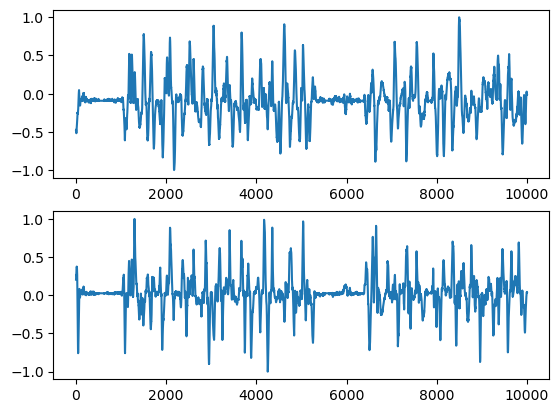

In [9]:
print("Neural data shape: ({num_sample}, {num_neuron})".
      format(num_sample=neural_data.shape[0],num_neuron=neural_data.shape[1]))
fig, axs = plt.subplots(2, 1)
axs[0].plot(vels_binned_norm[:,0])
axs[1].plot(vels_binned_norm[:,1])

In [10]:
#Number of examples after taking into account bins removed for lag alignment
neural_data = neural_data[:,select_neu]
num_examples=vels_binned_norm.shape[0]
print(vels_binned.shape)        
print(neural_data.shape)

# split train/valid/test
training_range=[0, 0.5]
testing_range=[0.5, 0.8]
valid_range=[0.8,1]

training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+1,np.int(np.round(training_range[1]*num_examples))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+1,np.int(np.round(testing_range[1]*num_examples))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+1,np.int(np.round(valid_range[1]*num_examples))-1)


#Get training data
X_train=neural_data[training_set,:]
y_train=vels_binned_norm[training_set,:]

#Get testing data
X_test=neural_data[testing_set,:]
y_test=vels_binned_norm[testing_set,:]

#Get validation data
X_valid=neural_data[valid_set,:]
y_valid=vels_binned_norm[valid_set,:]

(10000, 2)
(10000, 30)


C:\Users\tjulm\AppData\Local\Temp\ipykernel_20920\2719454005.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+1,np.int(np.round(training_range[1]*num_examples))-1)
C:\Users\tjulm\AppData\Local\Temp\ipykernel_20920\2719454005.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int

## 4. Point process observation

### 4.1 Check the number of spikes in each intervals

In [11]:
print("Neural data shape:(%d,%d)"%(neural_data.shape[0],neural_data.shape[1]))
no_spike = np.sum(neural_data==0)
one_spike = np.sum(neural_data==1)
more_than_one_spike = np.sum(neural_data>1)
num_intervals = neural_data.shape[0]*neural_data.shape[1]

# check the ratio
print("{:.1%} intervals have no more than one spike".format(1-more_than_one_spike/num_intervals))

Neural data shape:(10000,30)
98.8% intervals have no more than one spike


### 4.2 Eventplot for spikes

Number of Spike of each neuron in 1000 points:  [101. 114. 108.  87. 136.  47. 105.  23.  39.  98.]


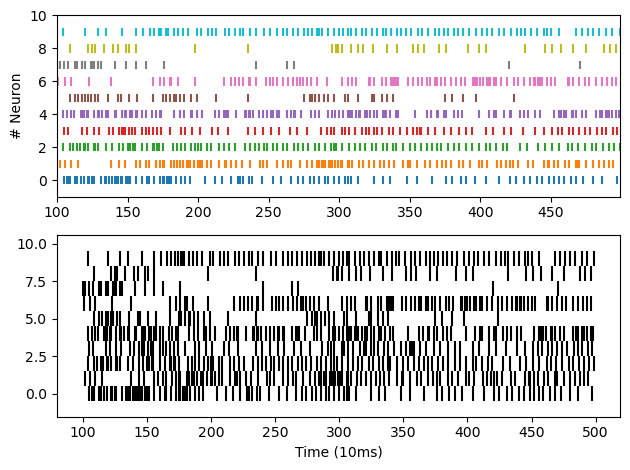

In [12]:
t_window = np.arange(100,500,1)
demo_data = neural_data[t_window,0:10]
num_neu = demo_data.shape[1]
colors1 = [f'C{i}' for i in range(num_neu)]
colors2 = 'black'

lineoffsets1 = list(range(num_neu))
linelengths1 = np.ones((num_neu),dtype=int)*0.5
lineoffsets2 = list(range(num_neu))
linelengths2 = 1

tt = np.arange(0,1000,1)
print("Number of Spike of each neuron in 1000 points: ", np.sum(demo_data.T,axis=1))

fig, axs = plt.subplots(2, 1)
for i in range(num_neu):
    event_data = t_window[0] + np.where(demo_data[:,i]>0)
    # the first parameter of eventplot is position
    # position: the occur time
    # but how is there any better way to process different length position array?
    axs[0].eventplot(event_data, color=colors1[i], lineoffsets=lineoffsets1[i], linelengths=linelengths1[i])
    axs[1].eventplot(event_data, color=colors2, lineoffsets=lineoffsets2[i], linelengths=linelengths2)

axs[0].set_xlim(t_window[0],t_window[-1])
axs[0].set_ylabel("# Neuron")
axs[1].set_xlabel("Time (10ms)")
fig.tight_layout()


## Decoding



start training


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 111.51it/s]


start predicting


100%|██████████| 2997/2997 [00:04<00:00, 680.65it/s]


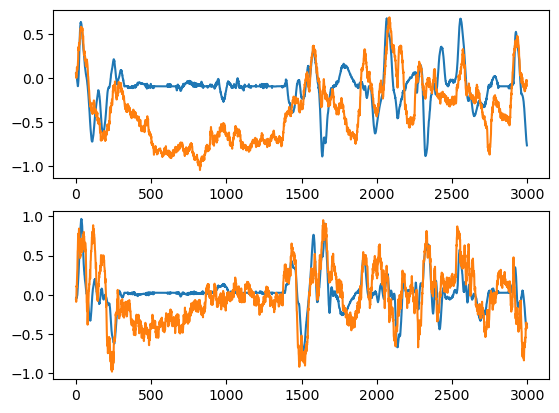

In [13]:
from Neural_Decoding.PP_decoders import KalmanFilterPP
# Q_factor should be changed based on the validation data
model_kfpp=KalmanFilterPP(Distribution="Poisson", Q_factor=100)
model_kfpp.fit(X_train,y_train)
state_kfpp = model_kfpp.predict(X_test,y_test)

fig, axs = plt.subplots(2, 1)
axs[0].plot(y_test[:,0])
axs[0].plot(state_kfpp[:,0])

axs[1].plot(y_test[:,1])
axs[1].plot(state_kfpp[:,1])
plt.show()

## Save Data

In [6]:
# import pickle

# data_folder='' #FOLDER YOU WANT TO SAVE THE DATA TO

# with open(data_folder+'example_data_s1.pickle','wb') as f:
#     pickle.dump([neural_data,vels_binned],f)